Data loaded successfully.
DataFrame shape: (1407328, 6)


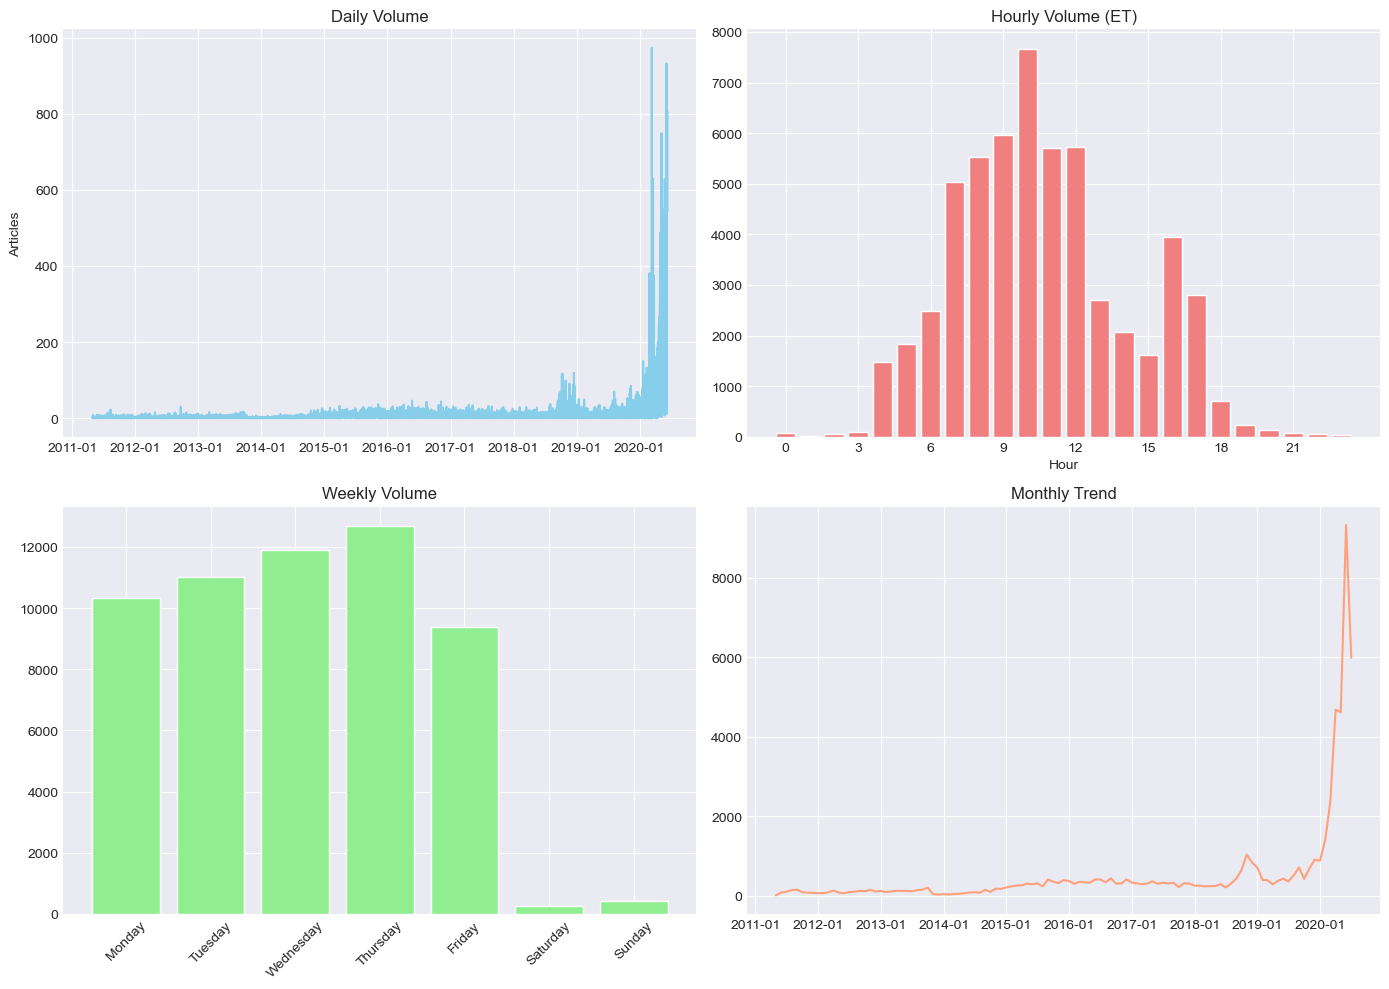

TypeError: Invalid comparison between dtype=datetime64[ns, UTC-04:00] and Timestamp

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import sys

from src import load_csv_finantial_news_data

sys.path.append('../../src')

data_path = '../../data/news/raw_analyst_ratings.csv'
stock_news = load_csv_finantial_news_data(data_path)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [10, 5]

def prep_ts(df, date_col='date'):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    # Drop rows where the date conversion failed (resulting in NaT)
    df.dropna(subset=[date_col], inplace=True)
    if not df.empty:
        try:
            df[date_col] = df[date_col].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
        except TypeError:
            print(f"Warning: Datetime column '{date_col}' already has timezone information. Proceeding without localization and conversion.")
        df['date_only'] = df[date_col].dt.date
        df['hour'] = df[date_col].dt.hour
        df['day'] = df[date_col].dt.day_name()
        df['week'] = df[date_col].dt.isocalendar().week
        # Remove timezone info before converting to Period to avoid warning
        df['month'] = df[date_col].dt.tz_localize(None).dt.to_period('M')
    else:
        print("Warning: DataFrame is empty after attempting to parse the date column.")
    return df

stock_news = prep_ts(stock_news.copy())

def plot_freq(df):
    if not df.empty:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        daily = df.resample('D', on='date').size()
        axes[0, 0].plot(daily, color='skyblue')
        axes[0, 0].set_title('Daily Volume')
        axes[0, 0].set_ylabel('Articles')
        axes[0, 0].xaxis.set_major_formatter(DateFormatter("%Y-%m"))

        hourly = df['hour'].value_counts().sort_index()
        axes[0, 1].bar(hourly.index, hourly, color='lightcoral')
        axes[0, 1].set_title('Hourly Volume (ET)')
        axes[0, 1].set_xlabel('Hour')
        axes[0, 1].set_xticks(range(0, 24, 3))

        weekly = df['day'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        axes[1, 0].bar(weekly.index, weekly, color='lightgreen')
        axes[1, 0].set_title('Weekly Volume')
        axes[1, 0].tick_params(axis='x', rotation=45)


        monthly = df.resample('ME', on='date').size()
        axes[1, 1].plot(monthly, color='lightsalmon')
        axes[1, 1].set_title('Monthly Trend')
        axes[1, 1].xaxis.set_major_formatter(DateFormatter("%Y-%m"))

        plt.tight_layout()
        plt.show()
    else:
        print("DataFrame is empty, skipping plot_freq.")

if not stock_news.empty:
    plot_freq(stock_news)
else:
    print("DataFrame is empty, skipping plot_freq.")

def analyze_events(df, events):
    if not df.empty:
        results = {}
        for name, date in events.items():
            start = pd.to_datetime(date) - pd.Timedelta(days=7)
            end = pd.to_datetime(date) + pd.Timedelta(days=7)
            period = df[df['date'].between(start, end)]
            baseline = df['date'].dt.normalize().value_counts().mean()
            event_day = period[period['date'].dt.date == pd.to_datetime(date).date()]
            count = len(event_day)
            results[name] = {'date': date,
                             'articles': count,
                             'baseline': round(baseline, 1),
                             'change': round((count - baseline) / baseline * 100, 1)}
            plt.figure()
            period.resample('D', on='date').size().plot(title=f'Volume Around {name} ({date})', color='tomato')
            plt.axvline(pd.to_datetime(date), color='black', linestyle='--')
            plt.ylabel('Daily Articles')
            plt.grid(True, alpha=0.3)
            plt.show()
        return pd.DataFrame(results).T
    else:
        print("DataFrame is empty, skipping analyze_events.")
        return pd.DataFrame()

events = {
    'COVID': '2020-03-16',
    'Fed Hike': '2022-03-16',
    'FTX': '2022-11-11'
}

event_analysis = analyze_events(stock_news, events)
if not event_analysis.empty:
    print("\nEvent Impact:")
    from IPython.display import display
    display(event_analysis.style.background_gradient(subset=['change']))

def analyze_pubs(df):
    if not df.empty:
        top_n = 10
        top = df['publisher'].value_counts().head(top_n)
        plt.figure(figsize=(10, 6))
        top.plot(kind='barh', color='cadetblue')
        plt.title(f'Top {top_n} Publishers')
        plt.xlabel('Articles')
        plt.gca().invert_yaxis()
        plt.show()

        pub_stats = df.groupby('publisher').agg({'headline': 'count',
                                                 'vader_compound': 'mean',
                                                 'is_positive': 'mean',
                                                 'is_negative': 'mean'}).sort_values('headline', ascending=False).head(top_n)
        print("\nPublisher Sentiment:")
        display(pub_stats.style.background_gradient(subset=['vader_compound'], cmap='coolwarm').format({'is_positive': '{:.1%}', 'is_negative': '{:.1%}'}))

        if 'publisher' in df.columns and df['publisher'].astype(str).str.contains('@').any():
            df['pub_domain'] = df['publisher'].str.extract(r'@([\w.]+)')
            domains = df['pub_domain'].value_counts().head(10)
            plt.figure(figsize=(10, 5))
            domains.plot(kind='bar', color='mediumpurple')
            plt.title('Top Publisher Domains')
            plt.ylabel('Articles')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo emails in publishers column or the column does not exist.")

        if 'publisher' in df.columns and 'stock' in df.columns:
            top_pubs_list = pub_stats.index[:5]
            pub_stocks = df[df['publisher'].isin(top_pubs_list)]
            fig, axes = plt.subplots(2, 3, figsize=(16, 8))
            axes = axes.flatten()
            for idx, pub in enumerate(top_pubs_list):
                if idx < len(axes):
                    pub_stocks[pub_stocks['publisher'] == pub]['stock'].value_counts()[:10].plot(kind='barh', ax=axes[idx], color=f'C{idx + 4}')
                    axes[idx].set_title(f'{pub[:15]}...')
                    if idx in [3, 4]:
                        axes[idx].set_xlabel('Mentions')
            for i in range(len(top_pubs_list), len(axes)):
                fig.delaxes(axes[i])
            plt.tight_layout()
            plt.show()
        else:
            print("\n'publisher' or 'stock' column missing, skipping publisher-stock analysis.")

        return pub_stats
    else:
        print("DataFrame is empty, skipping analyze_pubs.")
        return pd.DataFrame()

publisher_stats = analyze_pubs(stock_news)

def analyze_timing(df):
    if not df.empty:
        if 'hour' in df.columns and 'headline' in df.columns and 'vader_compound' in df.columns:
            hourly = df.groupby('hour').agg({'headline': 'count', 'vader_compound': 'mean'})
            fig, ax1 = plt.subplots(figsize=(12, 6))
            ax1.bar(hourly.index, hourly['headline'], color='steelblue', alpha=0.7, label='Volume')
            ax1.set_xlabel('Hour (ET)')
            ax1.set_ylabel('Article Volume', color='steelblue')
            ax1.tick_params(axis='y', labelcolor='steelblue')
            ax1.set_xticks(range(0, 24))
            ax2 = ax1.twinx()
            ax2.plot(hourly.index, hourly['vader_compound'], color='firebrick', marker='o', label='Sentiment')
            ax2.axhline(0, color='gray', linestyle='--')
            ax2.set_ylabel('Avg Sentiment', color='firebrick')
            ax2.tick_params(axis='y', labelcolor='firebrick')
            plt.title('News Volume vs. Sentiment by Hour')
            fig.legend(loc='upper right')
            plt.grid(True, alpha=0.3)
            plt.show()

            peak_volume = hourly['headline'].idxmax()
            peak_sentiment = hourly['vader_compound'].idxmax()

            print("\nTrading Timing Insights:")
            print(f"Peak Volume: {peak_volume}:00 ET")
            print(f"Highest Sentiment: {peak_sentiment}:00 ET")
        else:
            print("\nMissing required columns ('hour', 'headline', 'vader_compound') for analyze_timing.")
    else:
        print("DataFrame is empty, skipping analyze_timing.")

analyze_timing(stock_news)
